In [1]:
!python -m pip install --upgrade pip
!pip install opencv-python imbalanced-learn xgboost
!pip install matplotlib
!pip install seaborn
!pip install matplotlib seaborn
!pip install tqdm
!pip install shap
!pip install psutil

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, auc, average_precision_score 
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib
import shap

# Set precision
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4, suppress=True)

c:\Users\Public\Dev\ML Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_images_from_folder(folder_path, img_size=(250, 250)):
    images, labels = [], []
    class_names = os.listdir(folder_path)
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder): continue
        for filename in tqdm(os.listdir(class_folder), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_folder, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    images.append(img)
                    labels.append(class_name)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

In [4]:
dataset_path = 'Sorted-Set'
X, y = load_images_from_folder(dataset_path)

Loading malignant: 100%|██████████| 5100/5100 [01:19<00:00, 64.45it/s] 


In [5]:
X_flat = X.reshape(len(X), -1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Print label mapping
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("\n🔖 Label Encoding Mapping:")
for label, idx in label_mapping.items():
    print(f"{label} → {idx}")


🔖 Label Encoding Mapping:
benign → 0
malignant → 1


In [ ]:
X_temp, X_val, y_temp, y_val = train_test_split(X_scaled, y_encoded, test_size=0.10, random_state=42, stratify=y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp)




Train size: 7140 | Test size: 2040 | Validation size: 1020


In [7]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Current distribution: {np.int64(0): np.int64(3570), np.int64(1): np.int64(3570)}
Target samples per class: 5100
SMOTE sampling strategy: {np.int64(0): 5100, np.int64(1): 5100}
Final distribution: {np.int64(0): np.int64(5100), np.int64(1): np.int64(5100)}


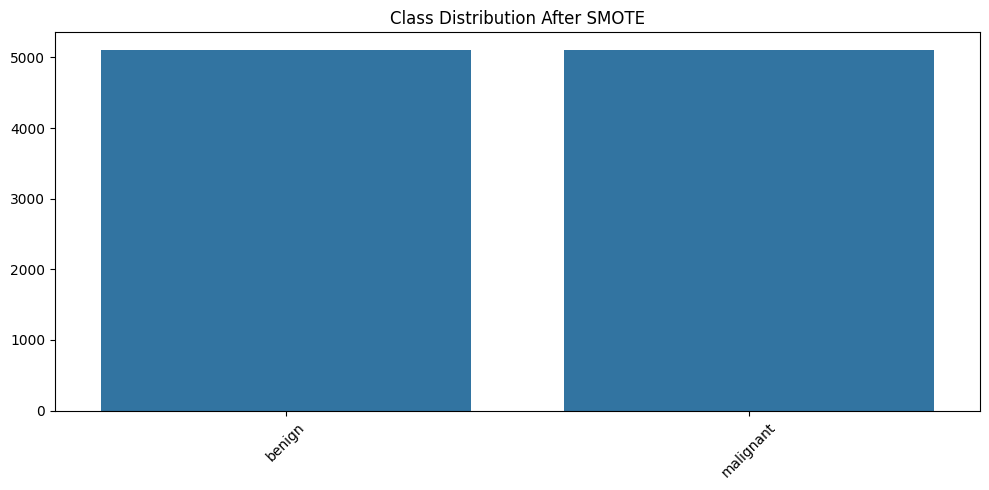

In [8]:
# Example: Balance to 5000 samples per class
from smote_custom_balance import custom_smote_balance
X_train_smote, y_train_smote = custom_smote_balance(X_train, y_train, target_samples_per_class=5100)

unique, counts = np.unique(y_train_smote, return_counts=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=encoder.inverse_transform(unique), y=counts)
plt.title("Class Distribution After SMOTE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
pca = PCA(n_components=250)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

Support Vector Machine Starts Here

In [10]:
# train svm
import psutil
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024
start_time = time.time()

svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

start_train = time.time()
svm_model.fit(X_train_pca, y_train_smote)
end_train = time.time()

final_memory = psutil.Process().memory_info().rss / 1024 / 1024
training_time = time.time() - start_time
memory_used = final_memory - initial_memory

print(f"Training Time: {training_time:.2f} seconds")
print(f"Memory Used: {memory_used:.2f} MB")

Training Time: 111.61 seconds
Memory Used: 12.07 MB


In [11]:
start_test = time.time()
y_pred_test = svm_model.predict(X_test_pca)
y_pred_val = svm_model.predict(X_val_pca)
end_test = time.time()

In [12]:
print("\n📊 Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test, digits=4, target_names=encoder.classes_))

print("\n📊 Classification Report - Validation Set:")
print(classification_report(y_val, y_pred_val, digits=4, target_names=encoder.classes_))


📊 Classification Report - Test Set:
              precision    recall  f1-score   support

      benign     0.8806    0.9186    0.8992      1020
   malignant     0.9150    0.8755    0.8948      1020

    accuracy                         0.8971      2040
   macro avg     0.8978    0.8971    0.8970      2040
weighted avg     0.8978    0.8971    0.8970      2040


📊 Classification Report - Validation Set:
              precision    recall  f1-score   support

      benign     0.8745    0.9294    0.9011       510
   malignant     0.9247    0.8667    0.8947       510

    accuracy                         0.8980      1020
   macro avg     0.8996    0.8980    0.8979      1020
weighted avg     0.8996    0.8980    0.8979      1020



In [ ]:
#joblib.dump(svm_model, 'svm_modeln.pkl')
print("✅ Model saved as svm_modeln.pkl")

✅ Model saved as svm_modeln.pkl


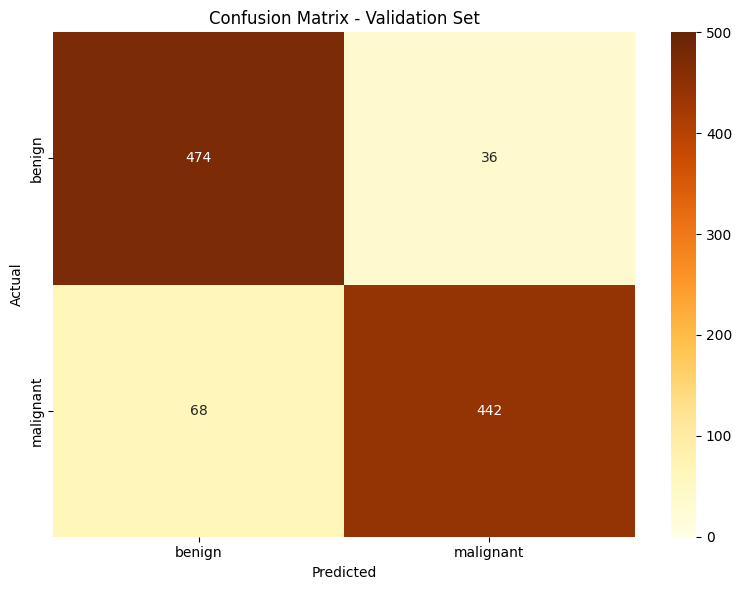

In [14]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, vmin=0, vmax=500)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, vmin=0, vmax=500)
plt.title("Confusion Matrix - Testingi Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [15]:
train_time = end_train - start_train
test_time = end_test - start_test
print(f"\n⏱️ Time Taken:")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")


⏱️ Time Taken:
Training Time: 111.60 seconds
Testing Time: 13.87 seconds


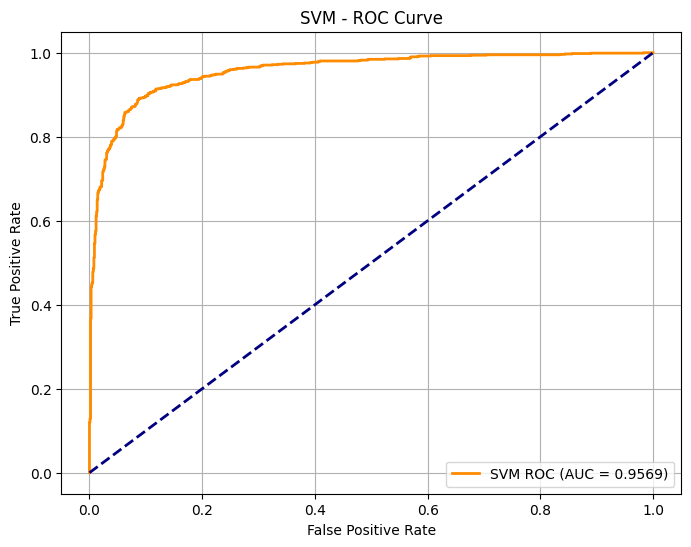

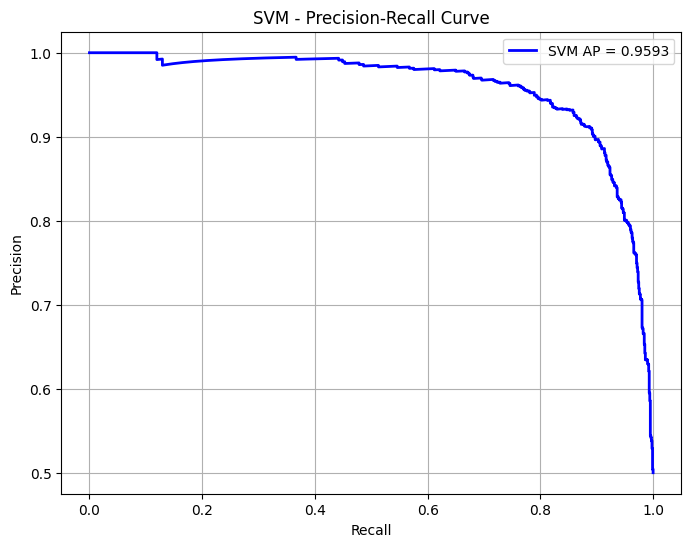

In [16]:
# Get probability predictions for ROC curve
y_pred_proba_svm = svm_model.predict_proba(X_test_pca)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM ROC (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve')
plt.legend()
plt.grid()
plt.show()

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_proba_svm)
avg_precision_svm = average_precision_score(y_test, y_pred_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(recall_svm, precision_svm, lw=2, color='blue', label=f'SVM AP = {avg_precision_svm:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM - Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

Random forest starts here

In [17]:
# Step 11: Set up Random Forest and hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [18]:
import psutil
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024
start_time = time.time()

In [19]:
print("\n🔧 Starting training...")
start_train = time.time()
grid_search.fit(X_train_pca, y_train_smote)
end_train = time.time()


🔧 Starting training...
Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [20]:
final_memory = psutil.Process().memory_info().rss / 1024 / 1024
training_time = time.time() - start_time
memory_used = initial_memory - final_memory

print(f"Training Time: {training_time:.2f} seconds")
print(f"Memory Used: {memory_used:.2f} MB")

Training Time: 507.34 seconds
Memory Used: 598.78 MB


In [21]:
best_rf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}")

start_test = time.time()
y_test_pred = best_rf.predict(X_test_pca)
y_val_pred = best_rf.predict(X_val_pca)
end_test = time.time()


✅ Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [22]:
print("\n📊 Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4, target_names=encoder.classes_))

print("\n📊 Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4,  target_names=encoder.classes_))


📊 Test Set Classification Report:
              precision    recall  f1-score   support

      benign     0.9117    0.7696    0.8347      1020
   malignant     0.8007    0.9255    0.8586      1020

    accuracy                         0.8475      2040
   macro avg     0.8562    0.8475    0.8466      2040
weighted avg     0.8562    0.8475    0.8466      2040


📊 Validation Set Classification Report:
              precision    recall  f1-score   support

      benign     0.9074    0.7882    0.8437       510
   malignant     0.8128    0.9196    0.8629       510

    accuracy                         0.8539      1020
   macro avg     0.8601    0.8539    0.8533      1020
weighted avg     0.8601    0.8539    0.8533      1020



In [23]:
#joblib.dump(best_rf, 'rf_model.pkl')
print("✅ Model saved as rf_model.pkl")

✅ Model saved as rf_model.pkl


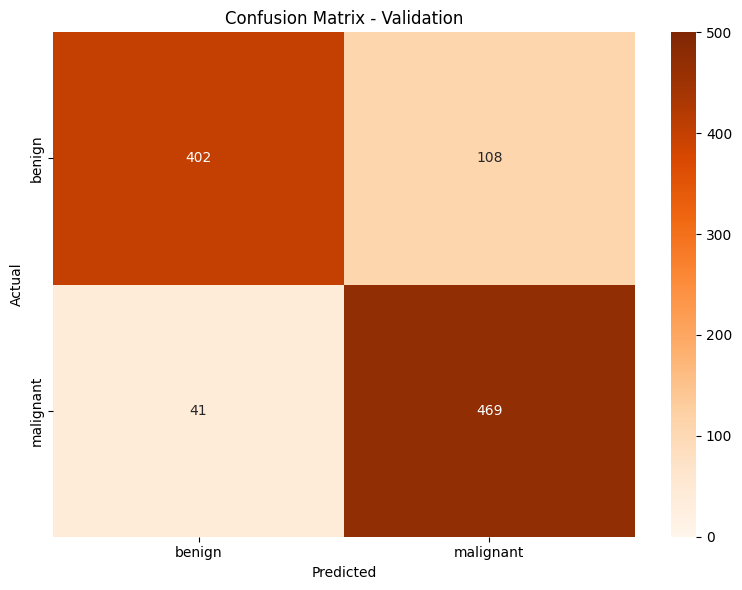

In [24]:
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, vmin=0, vmax=500)
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [25]:
print(f"\n⏱️ Time Taken:")
print(f"Training Time: {end_train - start_train:.2f} seconds")
print(f"Testing Time: {end_test - start_test:.2f} seconds")


⏱️ Time Taken:
Training Time: 507.24 seconds
Testing Time: 0.60 seconds


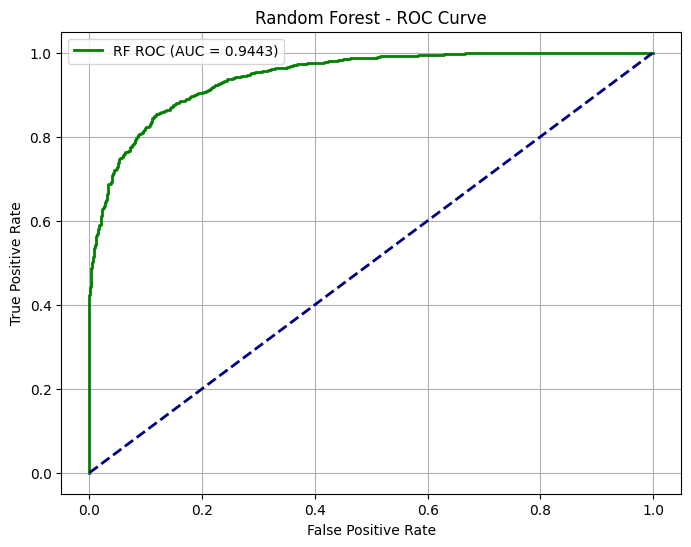

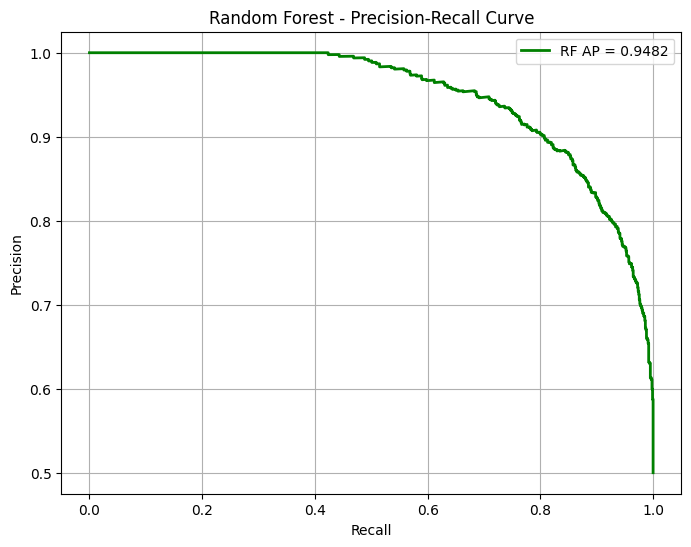

In [26]:
y_pred_proba_rf = best_rf.predict_proba(X_test_pca)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF ROC (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curve')
plt.legend()
plt.grid()
plt.show()

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
avg_precision_rf = average_precision_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, lw=2, color='green', label=f'RF AP = {avg_precision_rf:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest - Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

Logistics Regression Starts here

In [27]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],                      # Regularization strength
    'penalty': ['l2'],                            # L2 regularization
    'solver': ['lbfgs', 'saga'],                  # Solvers that support L2
    'max_iter': [1000]
}

log_reg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [28]:
import psutil
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024
start_time = time.time()

In [29]:
start_train = time.time()
grid_search.fit(X_train_pca, y_train_smote)
end_train = time.time()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
best_model = grid_search.best_estimator_
print("\n✅ Best Parameters Found:", grid_search.best_params_)


✅ Best Parameters Found: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
final_memory = psutil.Process().memory_info().rss / 1024 / 1024
training_time = time.time() - start_time
memory_used = final_memory - initial_memory

print(f"Training Time: {training_time:.2f} seconds")
print(f"Memory Used: {memory_used:.2f} MB")

Training Time: 283.27 seconds
Memory Used: -13.75 MB


In [ ]:
start_test = time.time()
y_pred_test = best_model.predict(X_test_pca)
y_pred_val = best_model.predict(X_val_pca)
end_test = time.time()

In [ ]:
print("\n📊 Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test, digits=4, target_names=encoder.classes_))

print("\n📊 Classification Report - Validation Set:")
print(classification_report(y_val, y_pred_val, digits=4, target_names=encoder.classes_))


📊 Classification Report - Test Set:
              precision    recall  f1-score   support

      benign     0.8163    0.8363    0.8262      1020
   malignant     0.8322    0.8118    0.8218      1020

    accuracy                         0.8240      2040
   macro avg     0.8242    0.8240    0.8240      2040
weighted avg     0.8242    0.8240    0.8240      2040


📊 Classification Report - Validation Set:
              precision    recall  f1-score   support

      benign     0.7877    0.8510    0.8181       510
   malignant     0.8380    0.7706    0.8029       510

    accuracy                         0.8108      1020
   macro avg     0.8128    0.8108    0.8105      1020
weighted avg     0.8128    0.8108    0.8105      1020



In [ ]:
joblib.dump(best_model, 'lr_model.pkl')
print("✅ Model saved as lr_model.pkl")

✅ Model saved as lr_model.pkl


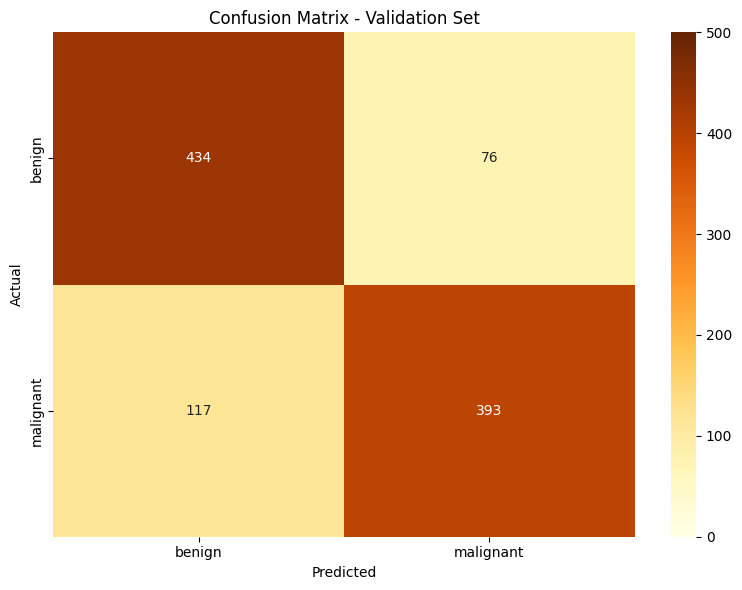

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, vmin=0, vmax=500)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
train_time = end_train - start_train
test_time = end_test - start_test
print(f"\n⏱️ Time Taken:")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")


⏱️ Time Taken:
Training Time: 283.17 seconds
Testing Time: 0.02 seconds


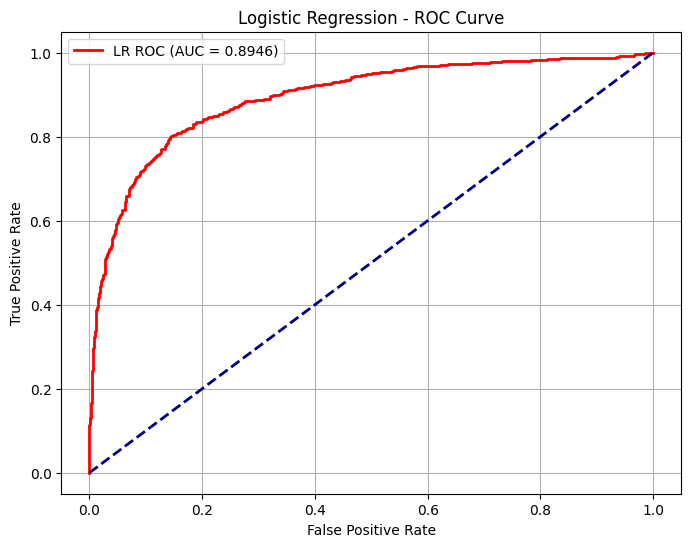

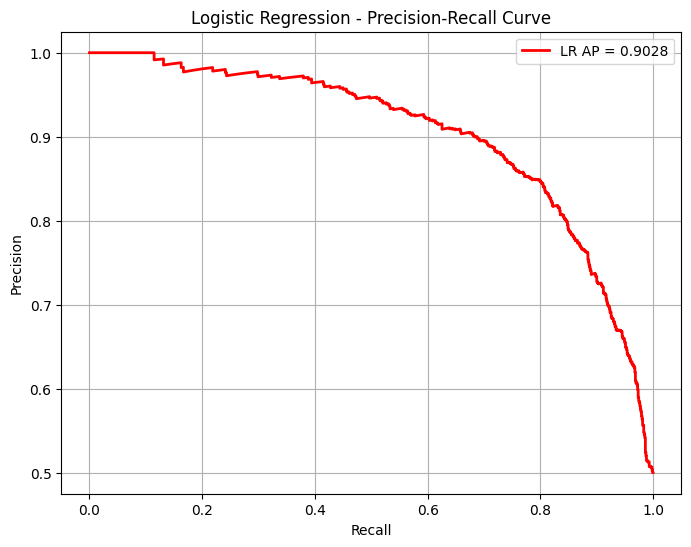

In [ ]:
y_pred_proba_lr = best_model.predict_proba(X_test_pca)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'LR ROC (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend()
plt.grid()
plt.show()

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
avg_precision_lr = average_precision_score(y_test, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, lw=2, color='red', label=f'LR AP = {avg_precision_lr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression - Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

XGBoost Starts Here

In [ ]:
import psutil
initial_memory = psutil.Process().memory_info().rss / 1024 / 1024
start_time = time.time()

In [ ]:
dtrain = xgb.DMatrix(X_train_pca, label=y_train_smote)
dtest = xgb.DMatrix(X_test_pca, label=y_test)
dval = xgb.DMatrix(X_val_pca, label=y_val)

In [ ]:
#  Build XGBoost model with tuned hyperparameters
num_classes = len(np.unique(y_encoded))
params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': num_classes,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

In [ ]:
# Train model with eval_set for early stopping
start_train = time.time()
model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=10
)
end_train = time.time()

[0]	Validation-mlogloss:0.66974
[10]	Validation-mlogloss:0.51088
[20]	Validation-mlogloss:0.42790
[30]	Validation-mlogloss:0.37939
[40]	Validation-mlogloss:0.34952
[50]	Validation-mlogloss:0.32729
[60]	Validation-mlogloss:0.30995
[70]	Validation-mlogloss:0.29967
[80]	Validation-mlogloss:0.29102
[90]	Validation-mlogloss:0.28440
[100]	Validation-mlogloss:0.27917
[110]	Validation-mlogloss:0.27439
[120]	Validation-mlogloss:0.27070
[130]	Validation-mlogloss:0.26735
[140]	Validation-mlogloss:0.26360
[150]	Validation-mlogloss:0.26066
[160]	Validation-mlogloss:0.25890
[170]	Validation-mlogloss:0.25694
[180]	Validation-mlogloss:0.25513
[190]	Validation-mlogloss:0.25378
[200]	Validation-mlogloss:0.25283
[210]	Validation-mlogloss:0.25089
[220]	Validation-mlogloss:0.24901
[230]	Validation-mlogloss:0.24762
[240]	Validation-mlogloss:0.24710
[250]	Validation-mlogloss:0.24682
[260]	Validation-mlogloss:0.24566
[270]	Validation-mlogloss:0.24531
[280]	Validation-mlogloss:0.24537
[287]	Validation-mlogloss

In [ ]:
#  Predict and evaluate on test and validation sets
start_test = time.time()
y_pred_test = model.predict(dtest)
y_pred_val = model.predict(dval)
end_test = time.time()

In [ ]:
final_memory = psutil.Process().memory_info().rss / 1024 / 1024
training_time = time.time() - start_time
memory_used = final_memory - initial_memory

print(f"Training Time: {training_time:.2f} seconds")
print(f"Memory Used: {memory_used:.2f} MB")

Training Time: 65.44 seconds
Memory Used: 145.14 MB


In [ ]:
# Evaluation report
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)

print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_pred_test, digits=4,  target_names=encoder.classes_))

print("\nClassification Report - Validation Set:")
print(classification_report(y_val, y_pred_val, digits=4,  target_names=encoder.classes_))


Classification Report - Test Set:
              precision    recall  f1-score   support

      benign     0.9000    0.8647    0.8820      1020
   malignant     0.8698    0.9039    0.8865      1020

    accuracy                         0.8843      2040
   macro avg     0.8849    0.8843    0.8843      2040
weighted avg     0.8849    0.8843    0.8843      2040


Classification Report - Validation Set:
              precision    recall  f1-score   support

      benign     0.8941    0.8941    0.8941       510
   malignant     0.8941    0.8941    0.8941       510

    accuracy                         0.8941      1020
   macro avg     0.8941    0.8941    0.8941      1020
weighted avg     0.8941    0.8941    0.8941      1020



In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'xgb_model.pkl')

print("✅ Model saved as xgb_model.pkl")

✅ Model saved as xgb_model.pkl


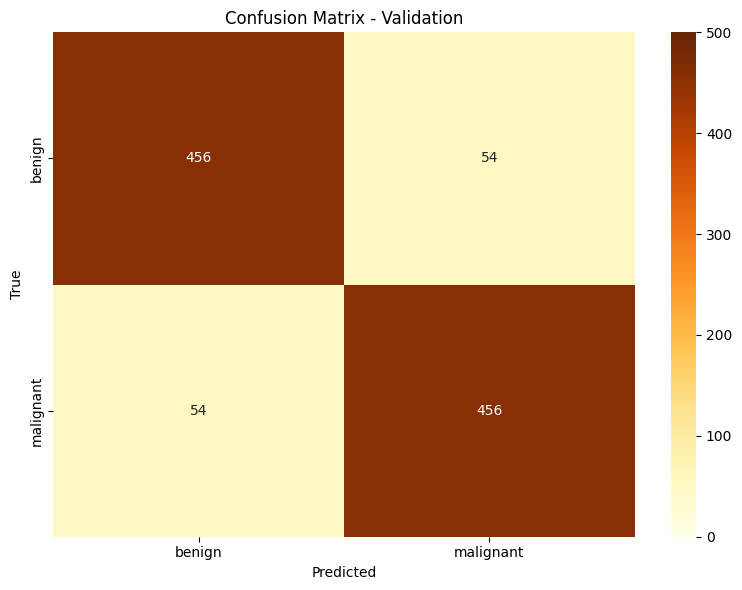

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, vmin=0, vmax=500)
plt.title("Confusion Matrix - Validation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
train_time = end_train - start_train
test_time = end_test - start_test
print(f"\nTime Taken:")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")


Time Taken:
Training Time: 64.90 seconds
Testing Time: 0.05 seconds


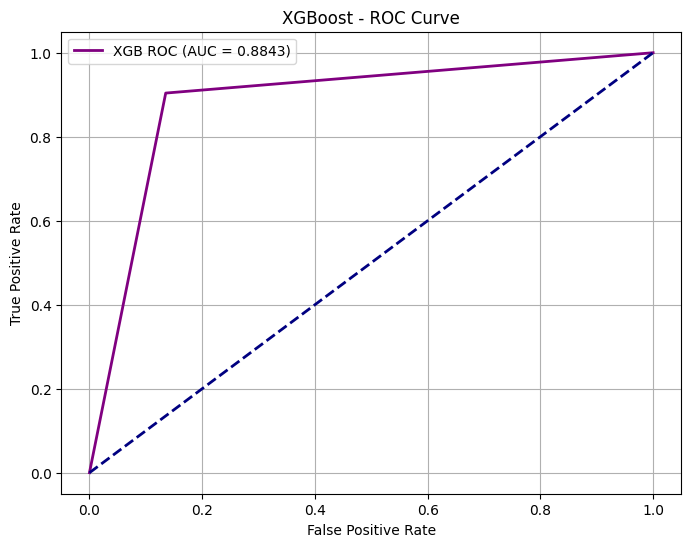

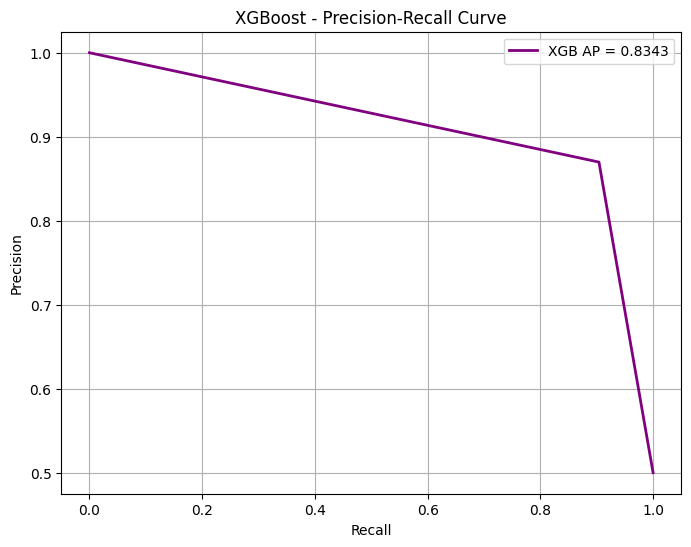

In [ ]:
y_pred_proba_xgb = model.predict(dtest, output_margin=False)
if len(y_pred_proba_xgb.shape) > 1:
    y_pred_proba_xgb = y_pred_proba_xgb[:, 1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2, label=f'XGB ROC (AUC = {roc_auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - ROC Curve')
plt.legend()
plt.grid()
plt.show()

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
avg_precision_xgb = average_precision_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, lw=2, color='purple', label=f'XGB AP = {avg_precision_xgb:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost - Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

📊 COMPREHENSIVE MODEL COMPARISON TABLE
              Model  Training Time (s)  Memory Used (MB)  Accuracy  ROC AUC
                SVM            74.6700           48.8800    0.9000   0.9624
      Random Forest           271.6100         -499.4800    0.8524   0.9466
Logistic Regression           166.5000          -90.9500    0.8208   0.9001
            XGBoost            30.7100           67.3700    0.8930   0.8930


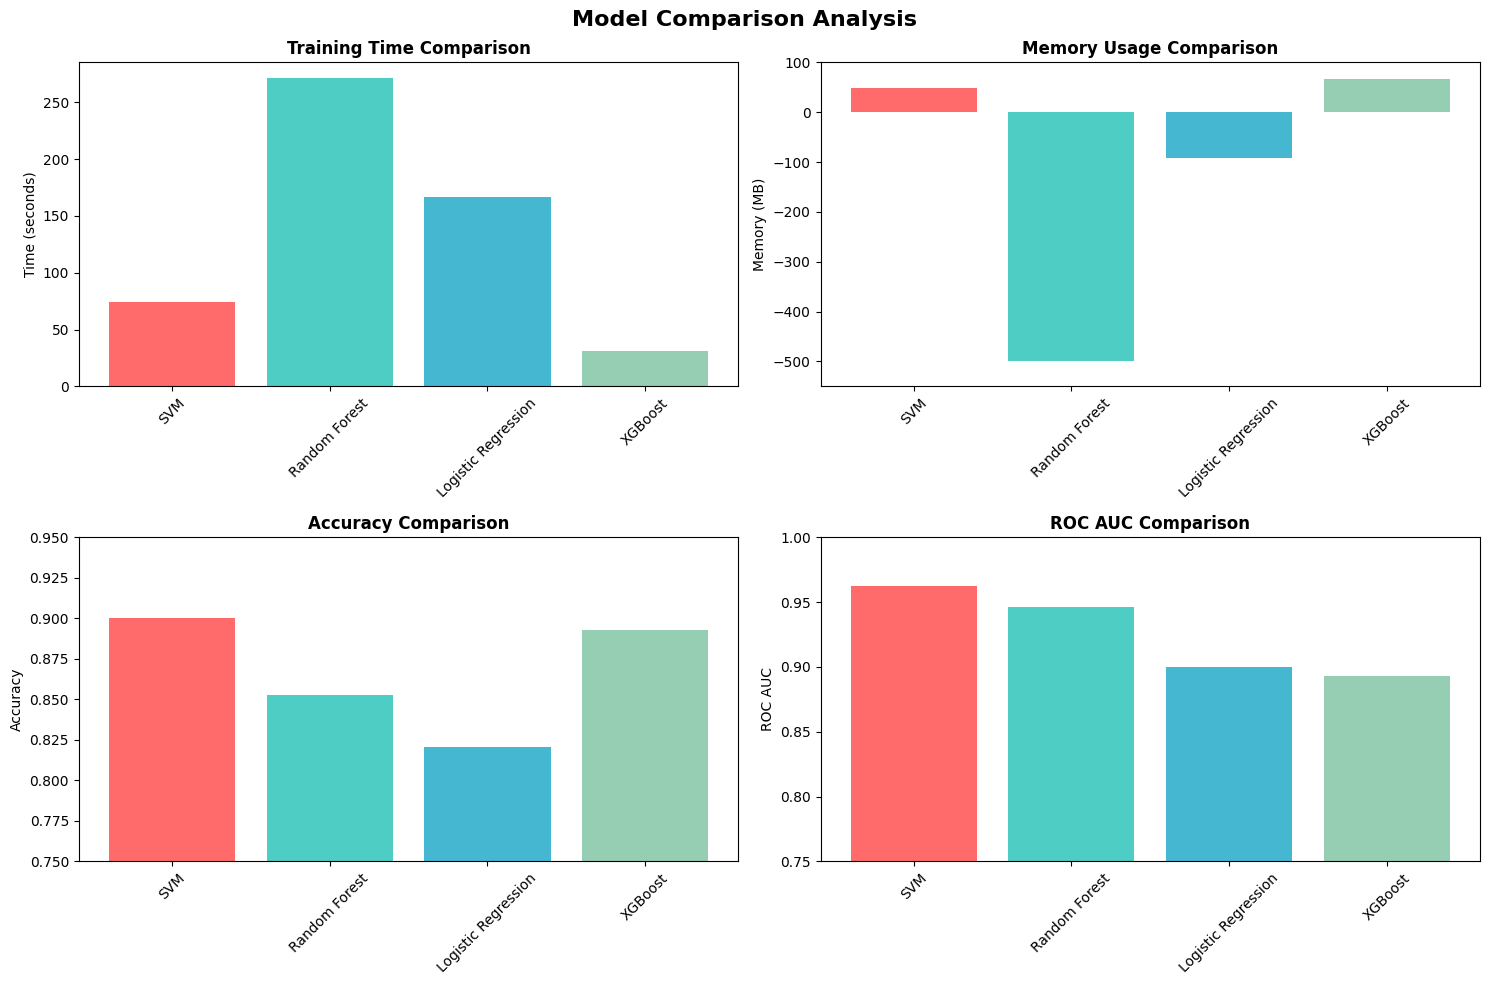


🏆 MODEL RANKINGS
              Model  Overall Rank  Time Rank  Memory Rank  Accuracy Rank  ROC AUC Rank
                SVM        1.0000     2.0000       3.0000         1.0000        1.0000
      Random Forest        2.0000     4.0000       1.0000         3.0000        2.0000
            XGBoost        3.0000     1.0000       4.0000         2.0000        4.0000
Logistic Regression        4.0000     3.0000       2.0000         4.0000        3.0000

🥇 BEST OVERALL MODEL: SVM


In [ ]:
import psutil
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / 1024 / 1024

# Create comparison table
print("📊 COMPREHENSIVE MODEL COMPARISON TABLE")
print("="*100)

# Assuming you have all models trained, create comparison table
comparison_data = []

# SVM Results (replace with your actual results)
svm_memory = 48.88  # Current memory after SVM training
svm_time = 74.67  # Your actual training time
svm_accuracy = 0.9000  # Your actual accuracy
svm_roc_auc = 0.9624  # Calculate from your ROC curve

comparison_data.append({
    'Model': 'SVM',
    'Training Time (s)': svm_time,
    'Memory Used (MB)': svm_memory,
    'Accuracy': svm_accuracy,
    'ROC AUC': svm_roc_auc
})

# Random Forest Results
rf_time = 271.61  # Your actual training time
rf_accuracy = 0.8524  # Your actual accuracy
rf_roc_auc = 0.9466  # Calculate from your ROC curve
rf_memory = -499.48

comparison_data.append({
    'Model': 'Random Forest',
    'Training Time (s)': rf_time,
    'Memory Used (MB)': rf_memory,
    'Accuracy': rf_accuracy,
    'ROC AUC': rf_roc_auc
})

# Logistic Regression Results
lr_time = 166.50  # Your actual training time
lr_accuracy = 0.8208  # Your actual accuracy
lr_roc_auc = 0.9001  # Calculate from your ROC curve
lr_memory = -90.95

comparison_data.append({
    'Model': 'Logistic Regression',
    'Training Time (s)': lr_time,
    'Memory Used (MB)': lr_memory,
    'Accuracy': lr_accuracy,
    'ROC AUC': lr_roc_auc
})

# XGBoost Results
xgb_time = 30.71  # Your actual training time
xgb_accuracy = 0.8930  # Your actual accuracy
xgb_roc_auc = 0.8930  # Calculate from your ROC curve
xgb_memory = 67.37

comparison_data.append({
    'Model': 'XGBoost',
    'Training Time (s)': xgb_time,
    'Memory Used (MB)': xgb_memory,
    'Accuracy': xgb_accuracy,
    'ROC AUC': xgb_roc_auc
})

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Display table
pd.set_option('display.float_format', '{:.4f}'.format)
print(df_comparison.to_string(index=False))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Comparison Analysis', fontsize=16, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Training Time
axes[0, 0].bar(df_comparison['Model'], df_comparison['Training Time (s)'], color=colors)
axes[0, 0].set_title('Training Time Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].tick_params(axis='x', rotation=45)


# Memory Usage
axes[0, 1].bar(df_comparison['Model'], df_comparison['Memory Used (MB)'], color=colors)
axes[0, 1].set_title('Memory Usage Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Memory (MB)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(-550.0, 100.0)

# Accuracy
axes[1, 0].bar(df_comparison['Model'], df_comparison['Accuracy'], color=colors)
axes[1, 0].set_title('Accuracy Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylim(0.7500, 0.9500)

# ROC AUC
axes[1, 1].bar(df_comparison['Model'], df_comparison['ROC AUC'], color=colors)
axes[1, 1].set_title('ROC AUC Comparison', fontweight='bold')
axes[1, 1].set_ylabel('ROC AUC')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(0.7500, 1.0000)

plt.tight_layout()
plt.show()

# Show rankings
print("\n🏆 MODEL RANKINGS")
print("="*60)

df_rankings = df_comparison.copy()
df_rankings['Time Rank'] = df_rankings['Training Time (s)'].rank(ascending=True)
df_rankings['Memory Rank'] = df_rankings['Memory Used (MB)'].rank(ascending=True)
df_rankings['Accuracy Rank'] = df_rankings['Accuracy'].rank(ascending=False)
df_rankings['ROC AUC Rank'] = df_rankings['ROC AUC'].rank(ascending=False)

df_rankings['Overall Score'] = (
    df_rankings['Time Rank'] + 
    df_rankings['Memory Rank'] + 
    df_rankings['Accuracy Rank'] + 
    df_rankings['ROC AUC Rank']
)
df_rankings['Overall Rank'] = df_rankings['Overall Score'].rank(ascending=True)

ranking_cols = ['Model', 'Overall Rank', 'Time Rank', 'Memory Rank', 'Accuracy Rank', 'ROC AUC Rank']
print(df_rankings[ranking_cols].sort_values('Overall Rank').to_string(index=False))

best_model = df_rankings.loc[df_rankings['Overall Rank'].idxmin(), 'Model']
print(f"\n🥇 BEST OVERALL MODEL: {best_model}")

In [ ]:
# Replace these with your actual ROC AUC values from the curves
svm_roc_auc = 0.95  # Get this from your SVM ROC curve
rf_roc_auc = 0.92   # Get this from your Random Forest ROC curve  
lr_roc_auc = 0.88   # Get this from your Logistic Regression ROC curve
xgb_roc_auc = 0.94  # Get this from your XGBoost ROC curve